# Загрузка библиотек

In [60]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
import gc

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from collections import Counter


# Загрузка даннык с kaggle

In [61]:
path = kagglehub.dataset_download('jehanbhathena/weather-dataset')
print('Путь к папке датасета', path)

Путь к папке датасета /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3


In [62]:
data = list()

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        label = dirname.split('/')[-1]
        image = os.path.join(dirname, filename)
        data.append((label, image))

In [63]:
df = pd.DataFrame(data, columns=['label', 'image'])
df.head()

,label,image
0,sandstorm,/root/.cache/kagglehub/datasets/jehanbhathena/...
1,sandstorm,/root/.cache/kagglehub/datasets/jehanbhathena/...
2,sandstorm,/root/.cache/kagglehub/datasets/jehanbhathena/...
3,sandstorm,/root/.cache/kagglehub/datasets/jehanbhathena/...
4,sandstorm,/root/.cache/kagglehub/datasets/jehanbhathena/...


# Информация о полученных данных

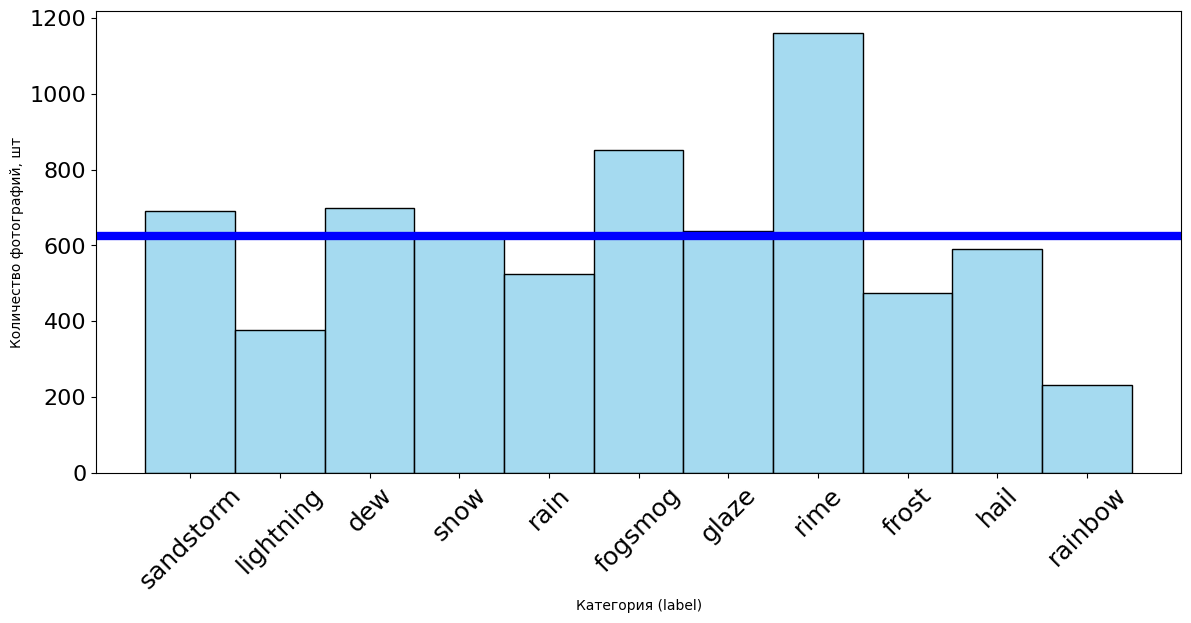

In [64]:
ax = sns.histplot(data=df, x='label', color='skyblue')
ax.figure.set_size_inches(14, 6)
plt.axhline(y=df.groupby('label').count().mean().mean(), lw=6, color='blue')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=16)
ax.set_ylabel('Количество фотографий, шт')
ax.set_xlabel('Категория (label)')

plt.show()

In [65]:
class_counts = Counter(df['label'])
print('Распределение классов: \n', class_counts)

Распределение классов: 
 Counter({'rime': 1160, 'fogsmog': 851, 'dew': 698, 'sandstorm': 692, 'glaze': 639, 'snow': 621, 'hail': 591, 'rain': 526, 'frost': 475, 'lightning': 377, 'rainbow': 232})


# Вывод примеров фотографий

In [66]:
examples = pd.DataFrame([])
unique_labels = df['label'].unique()
for label in unique_labels:
    examples = pd.concat([examples, df.query(f"label == '{label}'").sample(1)])

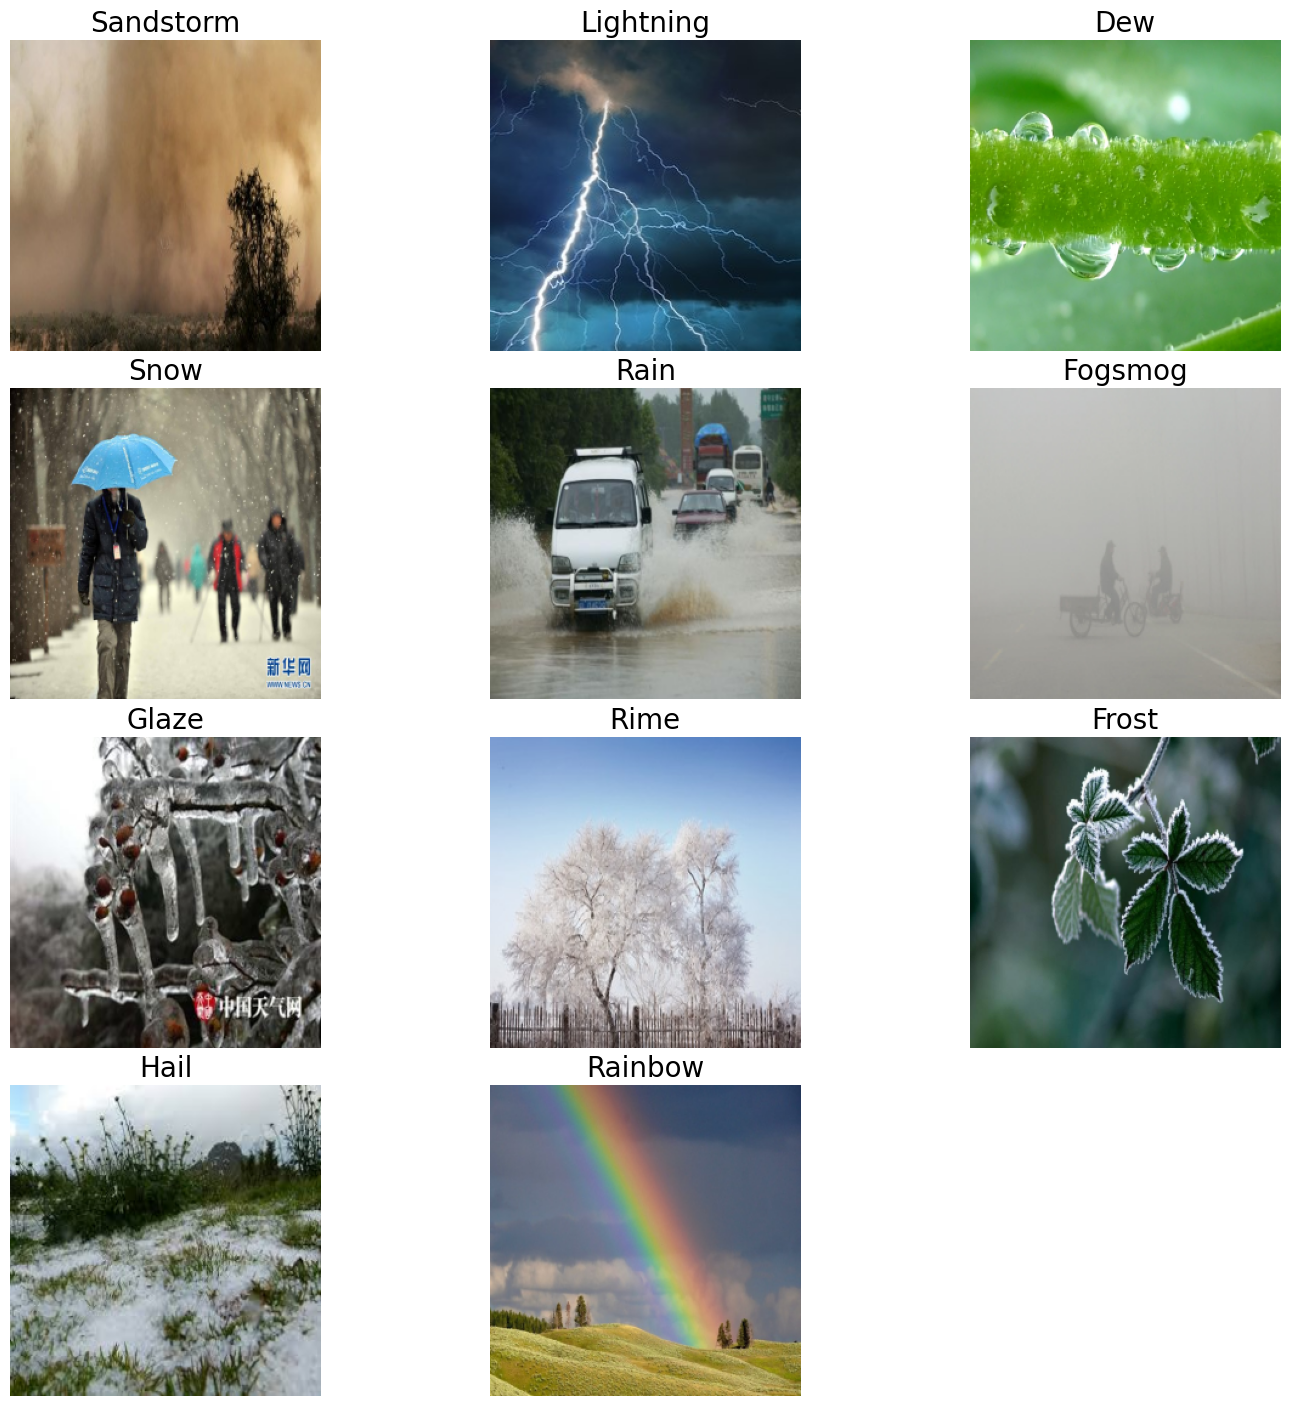

In [67]:
fig = plt.figure(figsize=(15, 14))
for index, row in examples.reset_index().iterrows():
    ax = plt.subplot(4, 3, index + 1)
    image = cv2.imread(row['image'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    ax.set_title(row['label'].title(), fontsize=20)
    ax.axis('off')

fig.tight_layout(pad=0.5)
plt.show()

# Предобработка данных


### Предобработка фотографий и создание тензоров

In [68]:
def process_image(img):
    try:
        pic = cv2.imread(img)
        pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
        pic = cv2.resize(pic, (256, 256), interpolation=cv2.INTER_AREA)
        pic = np.array(pic, dtype=np.float32)
        return pic
    except:
        return np.zeros(shape=(256, 256, 3), dtype=np.float32)

In [69]:
list_of_paths = df['image'].to_numpy()
images = [process_image(path) for path in list_of_paths]
images = np.array(images, dtype=np.float32)
images.shape

(6862, 256, 256, 3)

### Предобработка labels

In [70]:
def convert_categorical_to_number(label):
    return unique_labels.index(label)

In [71]:
unique_labels = list(unique_labels)
labels = df['label'].to_numpy()
func = np.vectorize(convert_categorical_to_number)
labels = func(labels)
labels

array([ 0,  0,  0, ..., 10, 10, 10])

### Разделение датасета

In [72]:
# - 70% для обучения (images_train, labels_train)
# - 15% для валидации (images_val, labels_val)
# - 15% для тестирования (images_test, labels_test)
images_train, images_test_and_val, labels_train, labels_test_and_val = train_test_split(images, labels, test_size=0.3,  random_state=42)
images_val, images_test, labels_val, labels_test = train_test_split(images, labels, test_size=0.5,  random_state=42)

### Перевод в формат для torch

In [73]:
images_train = torch.from_numpy(images_train).permute(0, 3, 1, 2)
images_val = torch.from_numpy(images_val).permute(0, 3, 1, 2)
images_test = torch.from_numpy(images_test).permute(0, 3, 1, 2)
labels_train = torch.from_numpy(labels_train)
labels_val = torch.from_numpy(labels_val)
labels_test = torch.from_numpy(labels_test)

print("Right sizes for torch:\n")
print("Train", images_train.shape, sep="\n")
print(labels_train.shape)
print("Validation", images_val.shape, sep="\n")
print(labels_val.shape)
print("Test", images_test.shape, sep="\n")
print(labels_test.shape)

Right sizes for torch:

Train
torch.Size([4803, 3, 256, 256])
torch.Size([4803])
Validation
torch.Size([3431, 3, 256, 256])
torch.Size([3431])
Test
torch.Size([3431, 3, 256, 256])
torch.Size([3431])


In [74]:
# удаляем ненужное
del images
gc.collect()

31859

# Загрузка в torch

In [75]:
# Гиперпараметры
args = {
    'epoch_num': 150,
    'lr': 1e-3,           # Learning Rate
    'weight_decay': 1e-3, # L2 Penalty
    'batch_size': 20
}

In [76]:
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')
print(args['device'])

cpu


In [77]:
class ImagesLabelsDataset(Dataset):
    def __init__(self, images_array, labels_array, scaler_feat=None, scaler_label=None):

        self.labels = labels_array
        self.images = images_array

    def __getitem__(self, idx):

        sample = self.images[idx]
        label  = self.labels[idx]

        return sample, label

    def __len__(self):
        return len(self.labels)

In [78]:
train_set = ImagesLabelsDataset(images_train, labels_train)
val_set = ImagesLabelsDataset(images_val, labels_val)
test_set = ImagesLabelsDataset(images_test, labels_test)

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          shuffle=True)
val_loader = DataLoader(val_set,
                         args['batch_size'],
                         shuffle=False)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         shuffle=False)

In [79]:
# Проверка
for batch in train_loader:
    img, lbl = batch
    print('Batch shape')
    print(img.size(), lbl.size())
    break

Batch shape
torch.Size([20, 3, 256, 256]) torch.Size([20])
